# Overall description

Receiver locations:
[-1950. -1850. -1750. -1650. -1550. -1450. -1350. -1250. -1150. -1050.
  -950.  -850.  -750.  -650.  -550.  -450.  -350.  -250.  -150.   -50.
    50.   150.   250.   350.   450.   550.   650.   750.   850.   950.
  1050.  1150.  1250.  1350.  1450.  1550.  1650.  1750.  1850.  1950.]



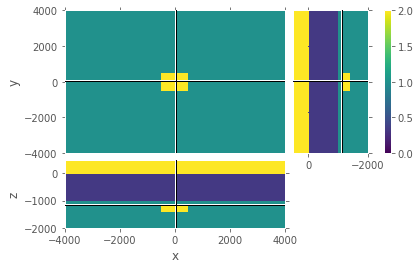


:: emg3d START :: 22:03:33 :: v0.11.0

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 0, 1, 2          verb      : 3
   Original grid  :  64 x  64 x  32     => 131,072 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   5 ;   5 ;   4   

   [hh:mm:ss]  rel. error                  [abs. error, last/prev]   l s

       h_
      2h_ \                            /
      4h_  \                  /\      / 
      8h_   \          /\    /  \    /  
     16h_    \    /\  /  \  /    \  /   
     32h_     \/\/  \/    \/      \/    

   [22:03:34]   5.227e-02  after   1 F-cycles   [2.918e-07, 0.052]   0 1
   [22:03:35]   6.108e-03  after   2 F-cycles   [3.410e-08, 0.117]   0 2
   [22:03:36]   7.466e-04  after   3 F-cycles   [4.168e-09, 0.122]   0 3
   [22:03:36]   1.135e-04  after   4 F-cycles   [6.334e-10, 0.152]   0 1
   [2

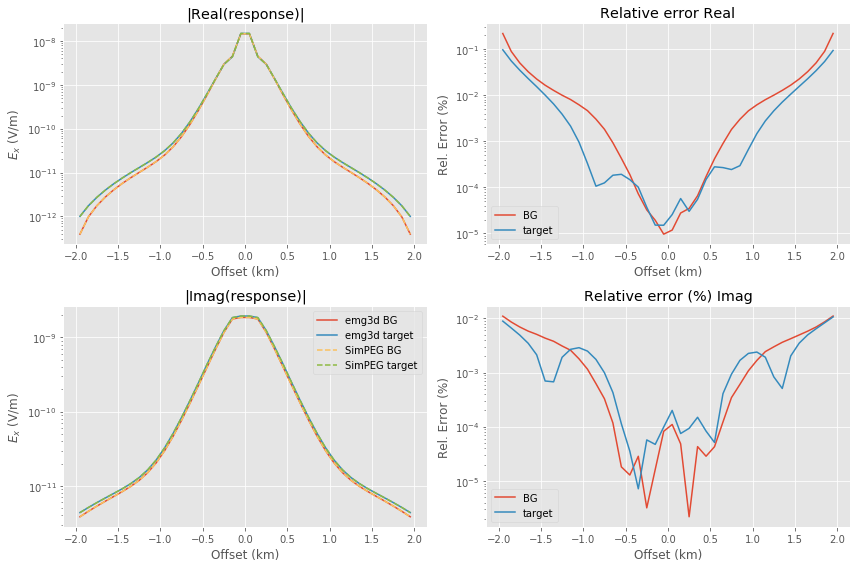

In [8]:

# A reproduction of "https://empymod.github.io/emg3d-gallery/gallery/comparisons/3D_triaxial_SimPEG.html" with SimPEG 0.14

import emg3d
import SimPEG as spg
import discretize
import numpy as np
import pymatsolver
import SimPEG.electromagnetics.frequency_domain as FDEM
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Depths (0 is sea-surface)
water_depth = 1000
target_x = np.r_[-500, 500]
target_y = target_x
target_z = -water_depth + np.r_[-400, -100]

# Resistivities
res_air = 2e8
res_sea = 0.33
res_back = [1., 2., 3.]  # Background in x-, y-, and z-directions
res_target = 100.

freq = 1.0

src = [-100, 100, 0, 0, -900, -900]

# Mesh the model space
cs = 100    # 100 m min_width of cells

pf = 1.15   # Padding factor x- and y-directions
pfz = 1.35  # .              z-direction
npadx = 12  # Nr of padding in x- and y-directions
npadz = 9   # .                z-direction

domain_x = 4000            # x- and y-domain
domain_z = - target_z[0]   # z-domain

# Create mesh
mesh = discretize.TensorMesh(
    [[(cs, npadx, -pf), (cs, int(domain_x/cs)), (cs, npadx, pf)],
     [(cs, npadx, -pf), (cs, int(domain_x/cs)), (cs, npadx, pf)],
     [(cs, npadz, -pfz), (cs, int(domain_z/cs)), (cs, npadz, pfz)]]
)

# Center mesh
mesh.x0 = np.r_[-mesh.hx.sum()/2, -mesh.hy.sum()/2, -mesh.hz[:-npadz].sum()]

# Create the source field for this mesh and given frequency
sfield = emg3d.fields.get_source_field(mesh, src, freq, strength=0)

# We take the receiver locations at the actual CCx-locations
rec_x = mesh.vectorCCx[12:-12]
print(f"Receiver locations:\n{rec_x}\n")

# Layered_background
res_x = res_air*np.ones(mesh.nC)
res_x[mesh.gridCC[:, 2] <= 0] = res_sea

res_y = res_x.copy()
res_z = res_x.copy()

res_x[mesh.gridCC[:, 2] <= -water_depth] = res_back[0]
res_y[mesh.gridCC[:, 2] <= -water_depth] = res_back[1]
res_z[mesh.gridCC[:, 2] <= -water_depth] = res_back[2]

res_x_bg = res_x.copy()
res_y_bg = res_y.copy()
res_z_bg = res_z.copy()

# Include the target
target_inds = (
    (mesh.gridCC[:, 0] >= target_x[0]) & (mesh.gridCC[:, 0] <= target_x[1]) &
    (mesh.gridCC[:, 1] >= target_y[0]) & (mesh.gridCC[:, 1] <= target_y[1]) &
    (mesh.gridCC[:, 2] >= target_z[0]) & (mesh.gridCC[:, 2] <= target_z[1])
)
res_x[target_inds] = res_target
res_y[target_inds] = res_target
res_z[target_inds] = res_target

# Create emg3d-models for given frequency
pmodel = emg3d.models.Model(mesh, res_x, res_y, res_z)
pmodel_bg = emg3d.models.Model(mesh, res_x_bg, res_y_bg, res_z_bg)

# Plot a slice
mesh.plot_3d_slicer(pmodel.res_x, zslice=-1100, clim=[0, 2],
                    xlim=(-4000, 4000), ylim=(-4000, 4000), zlim=(-2000, 500))
6
em3_tg = emg3d.solve(mesh, pmodel, sfield, verb=3, nu_pre=0,
                     semicoarsening=True)

em3_bg = emg3d.solve(mesh, pmodel_bg, sfield, verb=3, nu_pre=0,
                     semicoarsening=True)







# Set up the receivers
rx_locs = discretize.utils.ndgrid([rec_x, np.r_[0], np.r_[-water_depth]])
rx_list = [
    FDEM.receivers.PointElectricField(rx_locs, orientation='x', component="real"),
    FDEM.receivers.PointElectricField(rx_locs, orientation='x', component="imag")
]

# We use the emg3d-source-vector, to ensure we use the same in both cases
src_x_lim = [-100, 100]
src_loc_x = mesh.vectorNx[(mesh.vectorNx>=src_x_lim[0]) &
                          (mesh.vectorNx<=src_x_lim[1])]    # Station location in x-direction
src_loc_y = np.r_[0]    # Station location in y-direction
src_loc_z = np.r_[-900]    # Station location in z-direction
freq = np.r_[1]    # Source frequency in Hz

src_locs = spg.utils.ndgrid([src_loc_x, src_loc_y, src_loc_z])    # Sourrce coordinates
src_index_x = spg.utils.closestPoints(mesh, src_locs, gridLoc='Ex')[1:]    # [1:] is needed to drop the first point outside of the ssrc_x_lim
src_vec_x = np.zeros(mesh.nEx)
src_vec_y = np.zeros(mesh.nEy)
src_vec_z = np.zeros(mesh.nEz)
src_vec_x[src_index_x] = 1/len(src_index_x)    # Source vector, 1 means that edge is a source
src_vec = np.hstack((src_vec_x, src_vec_y, src_vec_z))    # Ensure src_vec has the same form as sfield.vector


src_sp = FDEM.sources.RawVec_e(rx_list, freq, src_vec)
src_list = [src_sp]


# Set up the PDE
survey = FDEM.Survey(src_list)
simulation = FDEM.simulation.Simulation3DElectricField(mesh, sigmaMap=spg.maps.IdentityMap(mesh), survey=survey,
                        Solver=pymatsolver.Pardiso)

# Create the simulation
simulation.pair(survey)






# Calculae the data
spg_tg_dobs = survey.dpred(np.vstack([1./res_x, 1./res_y, 1./res_z]).T)


spg_bg_dobs = survey.dpred(
        np.vstack([1./res_x_bg, 1./res_y_bg, 1./res_z_bg]).T)




# Plot the result and compare
ix1, ix2 = 12, 12
iy = 32
iz = 13


plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.title('|Real(response)|')
plt.semilogy(rec_x/1e3, np.abs(em3_bg.fx[ix1:-ix2, iy, iz].real))
plt.semilogy(rec_x/1e3, np.abs(em3_tg.fx[ix1:-ix2, iy, iz].real))
plt.semilogy(rec_x/1e3, np.abs(spg_bg_dobs[0:40]), 'C4--')
plt.semilogy(rec_x/1e3, np.abs(spg_tg_dobs[0:40]), 'C5--')
plt.xlabel('Offset (km)')
plt.ylabel('$E_x$ (V/m)')


plt.subplot(223)
plt.title('|Imag(response)|')
plt.semilogy(rec_x/1e3, np.abs(em3_bg.fx[ix1:-ix2, iy, iz].imag),
             label='emg3d BG')
plt.semilogy(rec_x/1e3, np.abs(em3_tg.fx[ix1:-ix2, iy, iz].imag),
             label='emg3d target')
plt.semilogy(rec_x/1e3, np.abs(spg_bg_dobs[40:]), 'C4--',
             label='SimPEG BG')
plt.semilogy(rec_x/1e3, np.abs(spg_tg_dobs[40:]), 'C5--',
             label='SimPEG target')
plt.xlabel('Offset (km)')
plt.ylabel('$E_x$ (V/m)')
plt.legend()


plt.subplot(222)
plt.title('Relative error Real')

err_bg = 100*np.abs((spg_bg_dobs[:40] -
                     em3_bg.fx[ix1:-ix2, iy, iz].real) /
                    em3_bg.fx[ix1:-ix2, iy, iz].real)
err_tg = 100*np.abs((spg_tg_dobs[:40] -
                     em3_tg.fx[ix1:-ix2, iy, iz].real) /
                    em3_tg.fx[ix1:-ix2, iy, iz].real)

plt.semilogy(rec_x/1e3, err_bg, label='BG')
plt.semilogy(rec_x/1e3, err_tg, label='target')

plt.xlabel('Offset (km)')
plt.ylabel('Rel. Error (%)')
plt.legend()

plt.subplot(224)
plt.title('Relative error (%) Imag')

err_bg = 100*np.abs((spg_bg_dobs[40:] -
                     em3_bg.fx[ix1:-ix2, iy, iz].imag) /
                    em3_bg.fx[ix1:-ix2, iy, iz].imag)
err_tg = 100*np.abs((spg_tg_dobs[40:] -
                     em3_tg.fx[ix1:-ix2, iy, iz].imag) /
                    em3_tg.fx[ix1:-ix2, iy, iz].imag)

plt.semilogy(rec_x/1e3, err_bg, label='BG')
plt.semilogy(rec_x/1e3, err_tg, label='target')

plt.xlabel('Offset (km)')
plt.ylabel('Rel. Error (%)')
plt.legend()

plt.tight_layout()
plt.show()


